<a href="https://colab.research.google.com/github/ronald-hk-chung/ssnotebook/blob/main/computer_vision/dog_cats_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction to Transfer Learning

**Mission Statement**

1. Understand transfer learning in image classification
2. Build a simple dog/cat classifier

## Notebook Preperation

In [1]:
!pip install -q git+https://github.com/ronald-hk-chung/sstorch.git
!pip install -q duckduckgo_search

from sstorch.learner import SSTLearner
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchinfo

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 18.2 MB/s eta 0:00:00


## Transfer Learning with Image data

Transfer learning is a technique in machine learning in which knowledge learned from a task is re-used in order to boost performance on a related task. It is a popular approach in deep learning where pre-trained models are used as the starting point on computer vision and natural language processing tasks given the vast compute and time resources required to develop neural network models on these problems.

For image classification, it is common to use a deep learning model pre-trained for a large and challenging image classification task such as the ImageNet 1000-class photograph classification. The research organization that develop models fo this competition and do well often release their final model under a permissive license for reuse. Thse model can take days or weeks to train on modern hardware.

In PyTorch, the [`torchvision.models`](https://pytorch.org/vision/stable/models.html) subpackage contains definitions of models for addressing different tasks, including image classification

## Download Custom Images - Dogs vs Cats

We will use duckduckgo-search to download Dogs vs Cats images.

In [2]:
import requests
import uuid
from duckduckgo_search import DDGS
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm

#Create datapath
data_path = Path('data')
(data_path / 'dogs').mkdir(parents=True, exist_ok=True)
(data_path / 'cats').mkdir(parents=True, exist_ok=True)

# Get URL to download images
dog_searches = DDGS().images(keywords='dogs',
                            max_results=300)

cat_searches = DDGS().images(keywords='cats',
                            max_results=300)

# Download data
for search in tqdm(dog_searches):
    try:
        im = Image.open(requests.get(search['image'], stream=True, timeout=5).raw).convert('RGB')
        im.save(f'data/dogs/{str(uuid.uuid4())}.jpg')
    except:
        pass

for search in tqdm(cat_searches):
    try:
        im = Image.open(requests.get(search['image'], stream=True, timeout=5).raw).convert('RGB')
        im.save(f'data/cats/{str(uuid.uuid4())}.jpg')
    except:
        pass

print(f"Total of Dog Images: {len(list(Path('data/dogs').glob('*.jpg')))}")
print(f"Total of Dog Images: {len(list(Path('data/cats').glob('*.jpg')))}")

  0%|          | 0/278 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/293 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Total of Dog Images: 203
Total of Dog Images: 239


## Prepare dataset and dataloaders with pretrained_transformation

In order to prepare our data to run through the pre-trained ResNet-34. Below steps are conducted:

1. Resize to (3, 224, 224)
2. Normalised with mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]

In [3]:
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# Create dataframe for images
df = pd.DataFrame(list(data_path.rglob('*.jpg')), columns=['path'])
df['class_names'] = df['path'].apply(lambda x: x.parent.name)
class_names = list(set(df['class_names']))
df['classes'] = df['class_names'].apply(lambda x: int(x=='cats'))
df_train, df_valid = train_test_split(df, test_size=0.2)

# image transformation
data_mean = [0.485, 0.456, 0.406]
data_std = [0.229, 0.224, 0.225]

tfms = T.Compose([
    T.Resize(size=(224, 224)),
    T.ToTensor(),
    T.Normalize(mean=data_mean,
                std=data_std)
])

rtfms = T.Compose([
    T.Normalize(mean=[0.0]* 3,
                std=list(map(lambda x: 1/x, data_std))),

    T.Normalize(mean=list(map(lambda x: -x, data_mean)),
                std=[1.0 * 3]),
    T.ToPILImage()
])

# Dataset for images
class DGDataset(Dataset):
  def __init__(self, df, tfms):
    self.df = df
    self.tfms = tfms
  def __len__(self):
    return len(self.df)
  def __getitem__(self, idx):
    img = self.tfms(Image.open(self.df.iloc[idx].path).convert('RGB'))
    label = torch.tensor(self.df.iloc[idx].classes, dtype=torch.float32)
    return img, label


train_ds = DGDataset(df=df_train,
                     tfms=tfms)

valid_ds = DGDataset(df=df_valid,
                     tfms=tfms)

train_dl = DataLoader(dataset=train_ds,
                      batch_size=16,
                      shuffle=True,
                      pin_memory=True,
                      drop_last=True)

valid_dl = DataLoader(dataset=valid_ds,
                      batch_size=16,
                      shuffle=False,
                      pin_memory=True,
                      drop_last=True)

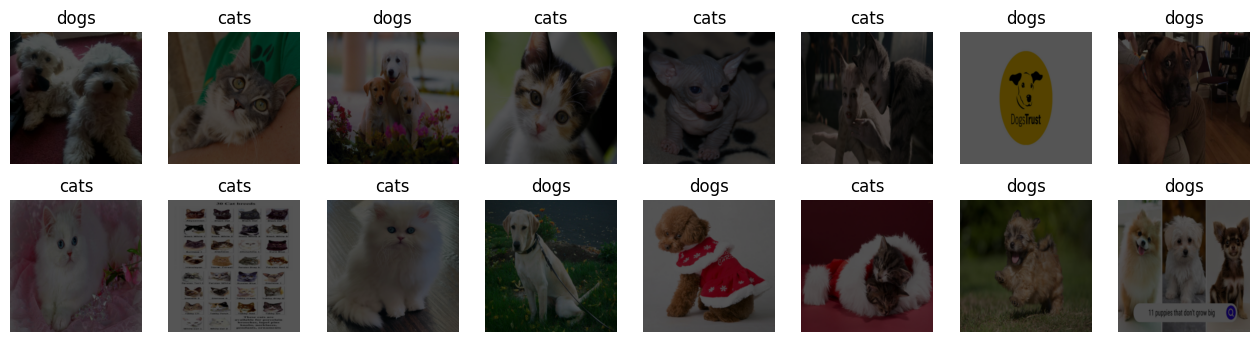

In [4]:
images, labels = next(iter(train_dl))

fig = plt.figure(figsize=(16, 4))
rows, cols = 2, 8
for i, image in enumerate(images):
    plt.subplot(rows, cols, i+1)
    plt.imshow(rtfms(image))
    plt.title(class_names[int(labels[i])])
    plt.axis(False)

## Visualize one batch of data

# Prepare for Pretrained model

**Downloading Pre-trained model**

We will use pre-trained resnet34 as a backbone of our classification problem

In [6]:
import torch
from torchvision.models import resnet34, ResNet34_Weights

model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 161MB/s]


**Replacing the head of model**
The 'head' of the model (fc layer in resnet case) usually is belongs to its classifier part. The featurizer part is usually left untouched in transfer learning as we try to leverage the model's ability to generate features for us.

We will replace the fc layer accordingly to the classes needed.

In [7]:
import torch.nn as nn

class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.classifier = nn.Sequential(nn.Linear(512, 128),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(128),
                                    nn.Dropout(0.4),
                                    nn.Linear(128, 32),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(32),
                                    nn.Dropout(0.4),
                                    nn.Linear(32, 1),
                                    nn.Sigmoid())

  def forward(self, X):
    X = self.classifier(X).squeeze()
    return X

model.fc = Classifier()

**Creating a Learner Class**

We will use `sstorch` to create a learner class for training

In [8]:
from sklearn.metrics import accuracy_score
from torch.nn.functional import binary_cross_entropy_with_logits

def metric_fn(y_logits, y):
    y_preds = np.round(y_logits.detach().cpu().numpy())
    y = y.detach().cpu().numpy()
    accuracy = accuracy_score(y, y_preds)
    return {'accuracy': accuracy}

loss_fn = nn.BCELoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

learner = SSTLearner(model=model,
                     loss_fn=loss_fn,
                     metric_fn=metric_fn,
                     optimizer=optimizer,
                     train_dataloader=train_dl,
                     valid_dataloader=valid_dl)

**Model Freezing**

We will need to *freeze* the featurizer of the model and only train the head of the model. This is done by using the `param.requires_grad=False`. In `sstorch`, we can use `freeze()`

In [9]:
learner.freeze()
learner.unfreeze(layers=['fc'])

**Checking the model summary**

In [10]:
learner.model_info()

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [16, 3, 224, 224]    [16]                 --                   Partial
├─Conv2d (conv1)                         [16, 3, 224, 224]    [16, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [16, 64, 112, 112]   [16, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [16, 64, 112, 112]   [16, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [16, 64, 112, 112]   [16, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [16, 64, 56, 56]     [16, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [16, 64, 56, 56]     [16, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [16, 64, 56, 56]     [16, 64, 56, 56]     (36,864)             False
│    │    

In [11]:
learner.train(10)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | LR: 1.0E-03 | train_loss: 0.489 | valid_loss: 0.335 
train_metric: {'accuracy': 0.756}
valid_metric: {'accuracy': 0.938}
----------------------------------------------------------------------------------------------------
Epoch: 2 | LR: 1.0E-03 | train_loss: 0.334 | valid_loss: 0.202 
train_metric: {'accuracy': 0.878}
valid_metric: {'accuracy': 0.95}
----------------------------------------------------------------------------------------------------
Epoch: 3 | LR: 1.0E-03 | train_loss: 0.25 | valid_loss: 0.157 
train_metric: {'accuracy': 0.918}
valid_metric: {'accuracy': 0.975}
----------------------------------------------------------------------------------------------------
Epoch: 4 | LR: 1.0E-03 | train_loss: 0.232 | valid_loss: 0.152 
train_metric: {'accuracy': 0.923}
valid_metric: {'accuracy': 0.938}
----------------------------------------------------------------------------------------------------
Epoch: 5 | LR: 1.0E-03 | train_loss: 0.174 | valid_loss: 0.133 
train_